# TMDB Movie Analysis Pipeline

In [ ]:
# Set up the Python environment to include the current directory in the module search path
import sys
sys.path.insert(0, '.')

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("TMDB_Movie_Pipeline") \
    .master("local[*]") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

print("Spark session created")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/27 02:39:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session created


26/01/27 02:39:29 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Step 1: Extract - Fetch Movies from TMDB API

In [2]:
from src.extract.fetch_movies import fetch_movies

raw_df = fetch_movies(spark)

print(f"Fetched {raw_df.count()} movies")
raw_df.select('id', 'title', 'release_date').show(5, truncate=False)

2026-01-27 02:39:55 | extract | INFO | Starting extraction for 19 movies
2026-01-27 02:39:55 | extract | INFO | Fetching movie ID: 0
2026-01-27 02:39:55 | extract | INFO | Attempt 1 of 3 for movie ID 0
2026-01-27 02:39:56 | extract | WARNING | Attempt 1 failed for movie ID 0: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?api_key=d703444a0cdc339616bf4ed9c0609a3b&append_to_response=credits
2026-01-27 02:39:56 | extract | INFO | Retrying in 1 seconds...
2026-01-27 02:39:57 | extract | INFO | Attempt 2 of 3 for movie ID 0
2026-01-27 02:39:58 | extract | WARNING | Attempt 2 failed for movie ID 0: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?api_key=d703444a0cdc339616bf4ed9c0609a3b&append_to_response=credits
2026-01-27 02:39:58 | extract | INFO | Retrying in 2 seconds...
2026-01-27 02:40:00 | extract | INFO | Attempt 3 of 3 for movie ID 0
2026-01-27 02:40:00 | extract | WARNING | Attempt 3 failed for movie ID 0: 404 Client Error: Not F

Fetched 18 movies
+------+----------------------------+------------+
|id    |title                       |release_date|
+------+----------------------------+------------+
|299534|Avengers: Endgame           |2019-04-24  |
|19995 |Avatar                      |2009-12-16  |
|140607|Star Wars: The Force Awakens|2015-12-15  |
|299536|Avengers: Infinity War      |2018-04-25  |
|597   |Titanic                     |1997-12-18  |
+------+----------------------------+------------+
only showing top 5 rows



## Step 2: Transform - Clean Data

In [3]:
from src.transform.clean_movies import clean_movies

cleaned_df = clean_movies(raw_df)

print(f"Cleaned data: {cleaned_df.count()} movies")
cleaned_df.select('title', 'genres', 'budget_musd', 'revenue_musd').show(5, truncate=False)

2026-01-27 02:40:39 | transform | INFO | Starting data cleaning
2026-01-27 02:40:42 | transform | INFO | Cleaning complete. Final row count: 18 


Cleaned data: 18 movies


[Stage 20:>                                                         (0 + 8) / 8]

+--------------------------------------------+----------------------------------------+-----------+------------+
|title                                       |genres                                  |budget_musd|revenue_musd|
+--------------------------------------------+----------------------------------------+-----------+------------+
|Titanic                                     |Drama|Romance                           |200.0      |2264.162353 |
|Harry Potter and the Deathly Hallows: Part 2|Adventure|Fantasy                       |125.0      |1341.511219 |
|Avatar                                      |Action|Adventure|Fantasy|Science Fiction|237.0      |2923.706026 |
|The Avengers                                |Science Fiction|Action|Adventure        |220.0      |1518.815515 |
|Avengers: Age of Ultron                     |Action|Adventure|Science Fiction        |235.0      |1405.403694 |
+--------------------------------------------+----------------------------------------+---------

## Step 3: Transform - Enrich Data

In [4]:
from src.transform.derived_metrics import add_derived_metrics

enriched_df = add_derived_metrics(cleaned_df)

print("Enriched data with profit and ROI")
enriched_df.select('title', 'profit_musd', 'roi', 'release_year').show(5, truncate=False)

2026-01-27 02:40:56 | transform | INFO | Starting data enrichment
2026-01-27 02:40:56 | transform | INFO | Enrichment complete


Enriched data with profit and ROI


+--------------------------------------------+-----------+-----------------+------------+
|title                                       |profit_musd|roi              |release_year|
+--------------------------------------------+-----------+-----------------+------------+
|Titanic                                     |2064.162353|11.320811765     |1997        |
|Harry Potter and the Deathly Hallows: Part 2|1216.511219|10.732089752     |2011        |
|Avatar                                      |2686.706026|12.33631234599156|2009        |
|The Avengers                                |1298.815515|6.903706886363636|2012        |
|Avengers: Age of Ultron                     |1170.403694|5.98044125106383 |2015        |
+--------------------------------------------+-----------+-----------------+------------+
only showing top 5 rows



## Step 4: Analysis - Best and Worst Performers

In [5]:
from src.analysis.kpi_rankings import get_highest_revenue_movies, get_highest_roi_movies

print("Top 5 Movies by Revenue:")
get_highest_revenue_movies(enriched_df, n=5).select('title', 'revenue_musd').show(truncate=False)

print("Top 5 Movies by ROI:")
get_highest_roi_movies(enriched_df, n=5).select('title', 'roi').show(truncate=False)

Top 5 Movies by Revenue:


+----------------------------+------------+
|title                       |revenue_musd|
+----------------------------+------------+
|Avatar                      |2923.706026 |
|Avengers: Endgame           |2799.4391   |
|Titanic                     |2264.162353 |
|Star Wars: The Force Awakens|2068.223624 |
|Avengers: Infinity War      |2052.415039 |
+----------------------------+------------+

Top 5 Movies by ROI:
+--------------------------------------------+-----------------+
|title                                       |roi              |
+--------------------------------------------+-----------------+
|Avatar                                      |12.33631234599156|
|Titanic                                     |11.320811765     |
|Jurassic World                              |11.14358296      |
|Harry Potter and the Deathly Hallows: Part 2|10.732089752     |
|Frozen II                                   |9.691223173333332|
+--------------------------------------------+----------------

## Step 5: Analysis - Franchise vs Standalone

In [6]:
from src.analysis.franchise_analysis import compare_franchise_vs_standalone

comparison = compare_franchise_vs_standalone(enriched_df)

print("Franchise vs Standalone Comparison:")
comparison.show(truncate=False)

2026-01-27 02:41:22 | analysis | INFO | Comparing franchise vs standalone movie performance
2026-01-27 02:41:25 | analysis | INFO |   Franchise:                            
2026-01-27 02:41:25 | analysis | INFO |     - Movie count: 16
2026-01-27 02:41:25 | analysis | INFO |     - Mean revenue: $1682.67M
2026-01-27 02:41:25 | analysis | INFO |     - Median ROI: 7.71x
2026-01-27 02:41:25 | analysis | INFO |   Standalone:
2026-01-27 02:41:25 | analysis | INFO |     - Movie count: 2
2026-01-27 02:41:25 | analysis | INFO |     - Mean revenue: $1765.14M
2026-01-27 02:41:25 | analysis | INFO |     - Median ROI: 7.91x


Franchise vs Standalone Comparison:


[Stage 38:=======>                                                  (1 + 7) / 8]

+------------+-----------+------------------+-----------------+----------------+------------------+------------------+
|is_franchise|movie_count|mean_revenue_musd |median_roi       |mean_budget_musd|mean_popularity   |mean_rating       |
+------------+-----------+------------------+-----------------+----------------+------------------+------------------+
|Franchise   |16         |1682.6684113749998|7.708641394117647|218.0           |21.709368750000003|7.38575           |
|Standalone  |2          |1765.1391585000001|7.913224775000001|180.0           |24.4107           |7.4350000000000005|
+------------+-----------+------------------+-----------------+----------------+------------------+------------------+



## Step 6: Visualization

2026-01-27 02:45:04 | visualization | INFO | Creating visualizations in data/analytics/plots/
2026-01-27 02:45:04 | visualization | INFO | Creating Revenue vs Budget plot
2026-01-27 02:45:05 | visualization | INFO | Creating ROI by Genre plot
2026-01-27 02:45:06 | visualization | INFO | Creating Popularity vs Rating plot
2026-01-27 02:45:06 | visualization | INFO | Creating Yearly Box Office plot
2026-01-27 02:45:07 | visualization | INFO | Creating Franchise vs Standalone plot
2026-01-27 02:45:08 | visualization | INFO | Created 5 visualizations


Created 5 visualizations

data/analytics/plots/revenue_vs_budget.png:


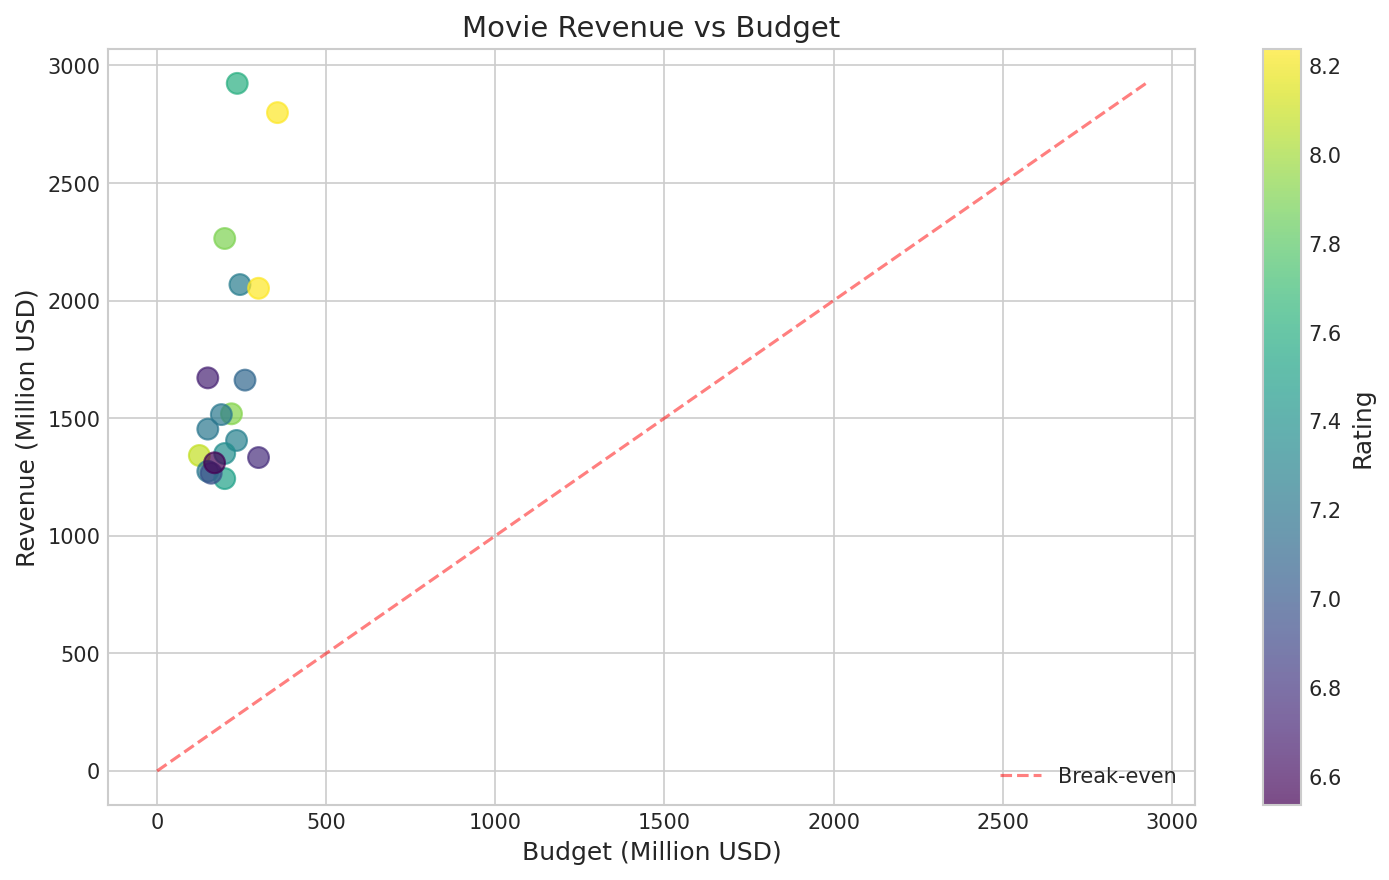


data/analytics/plots/roi_by_genre.png:


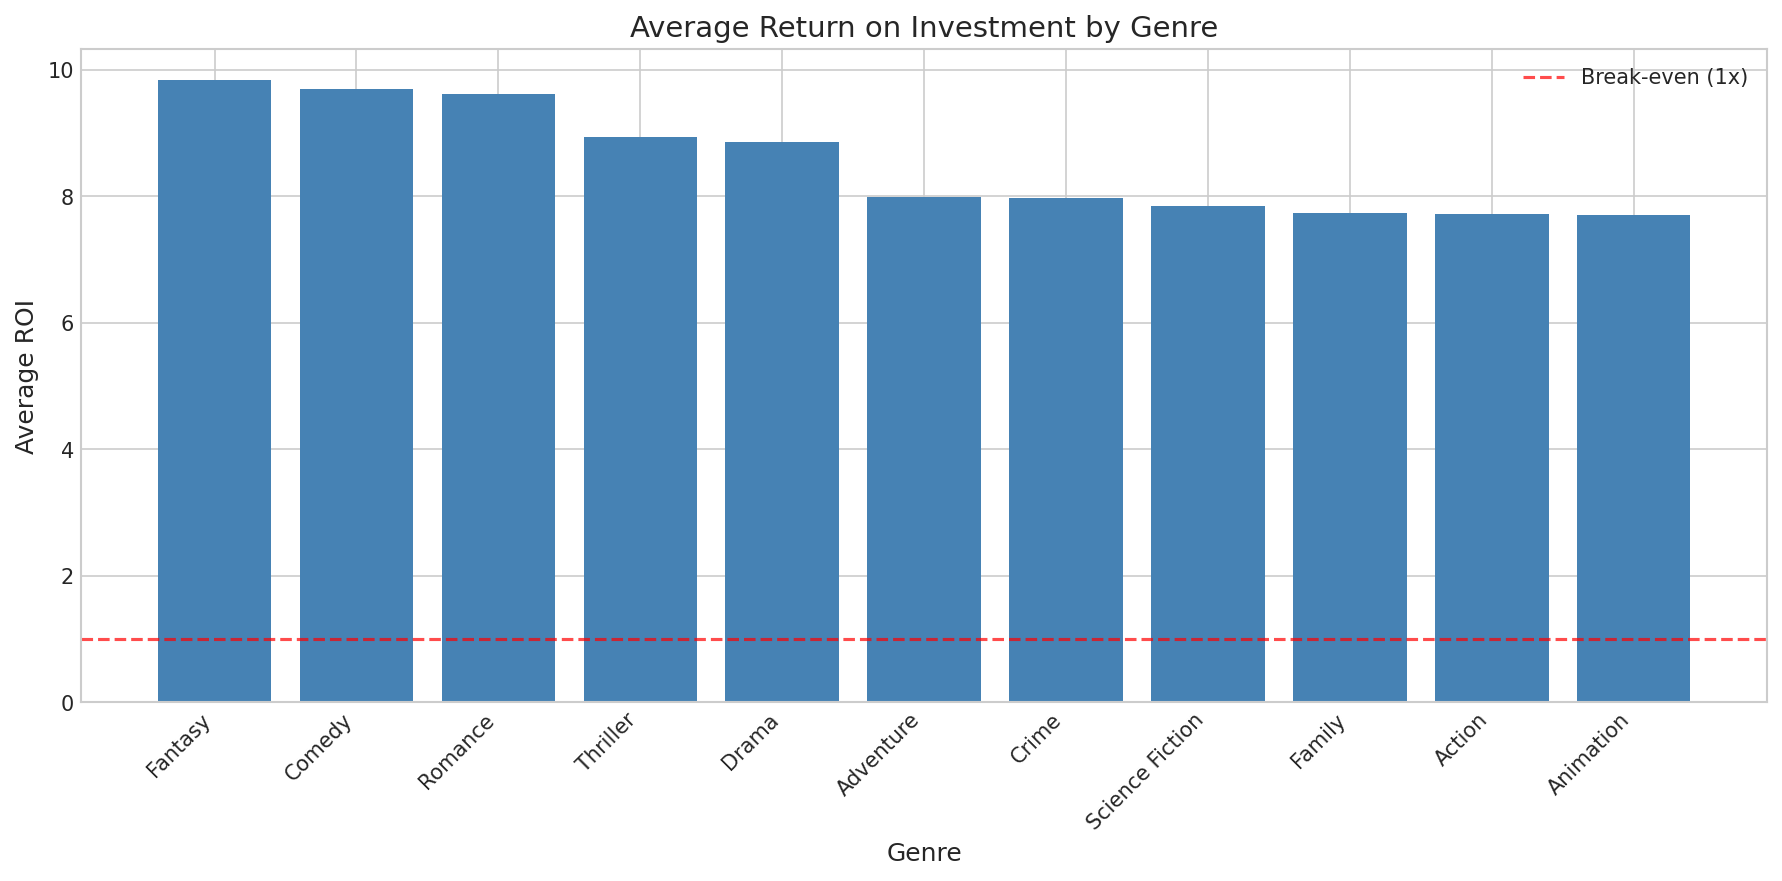


data/analytics/plots/popularity_vs_rating.png:


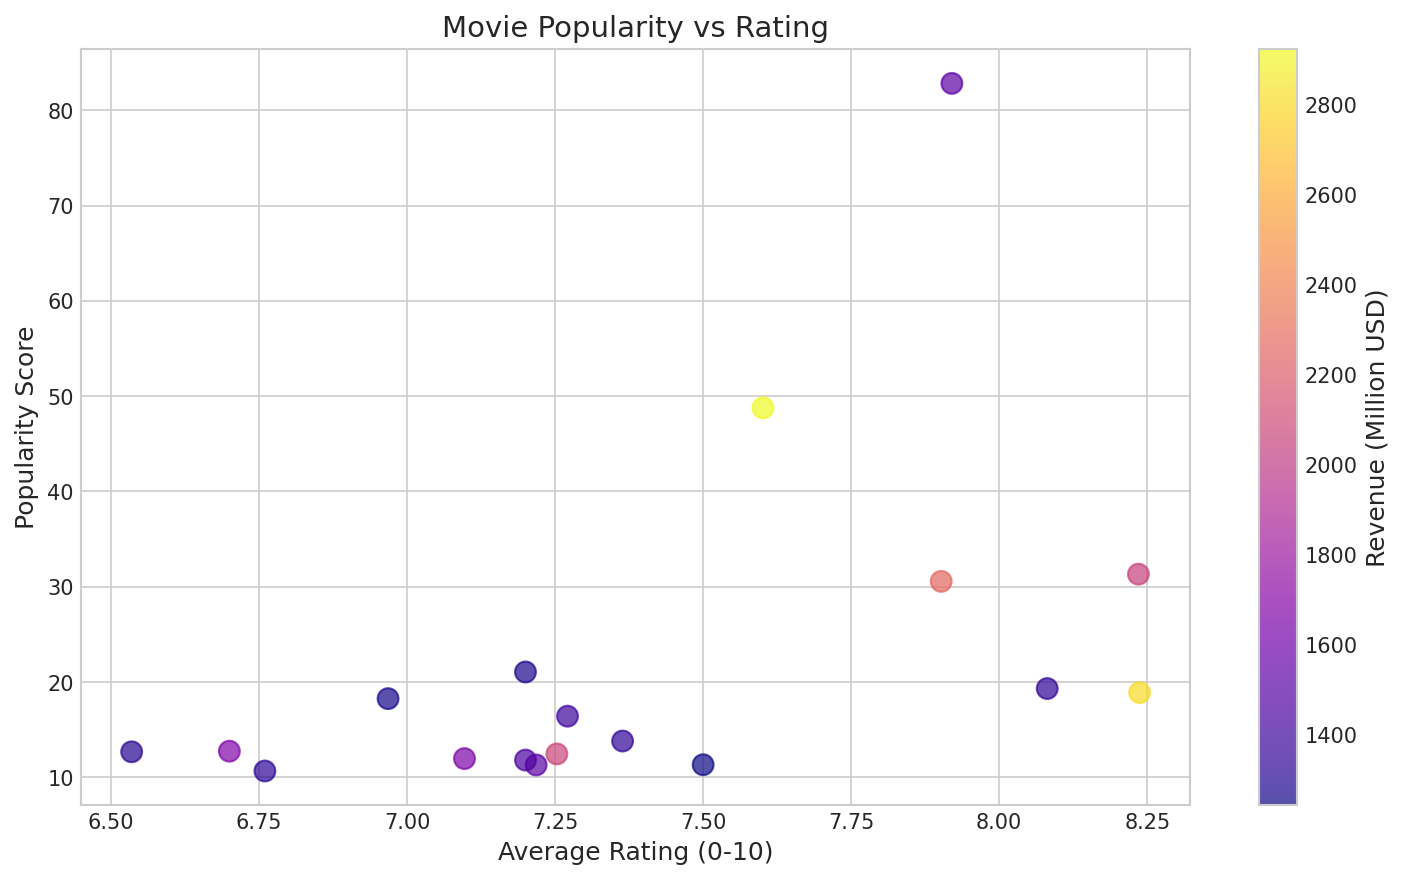


data/analytics/plots/yearly_box_office.png:


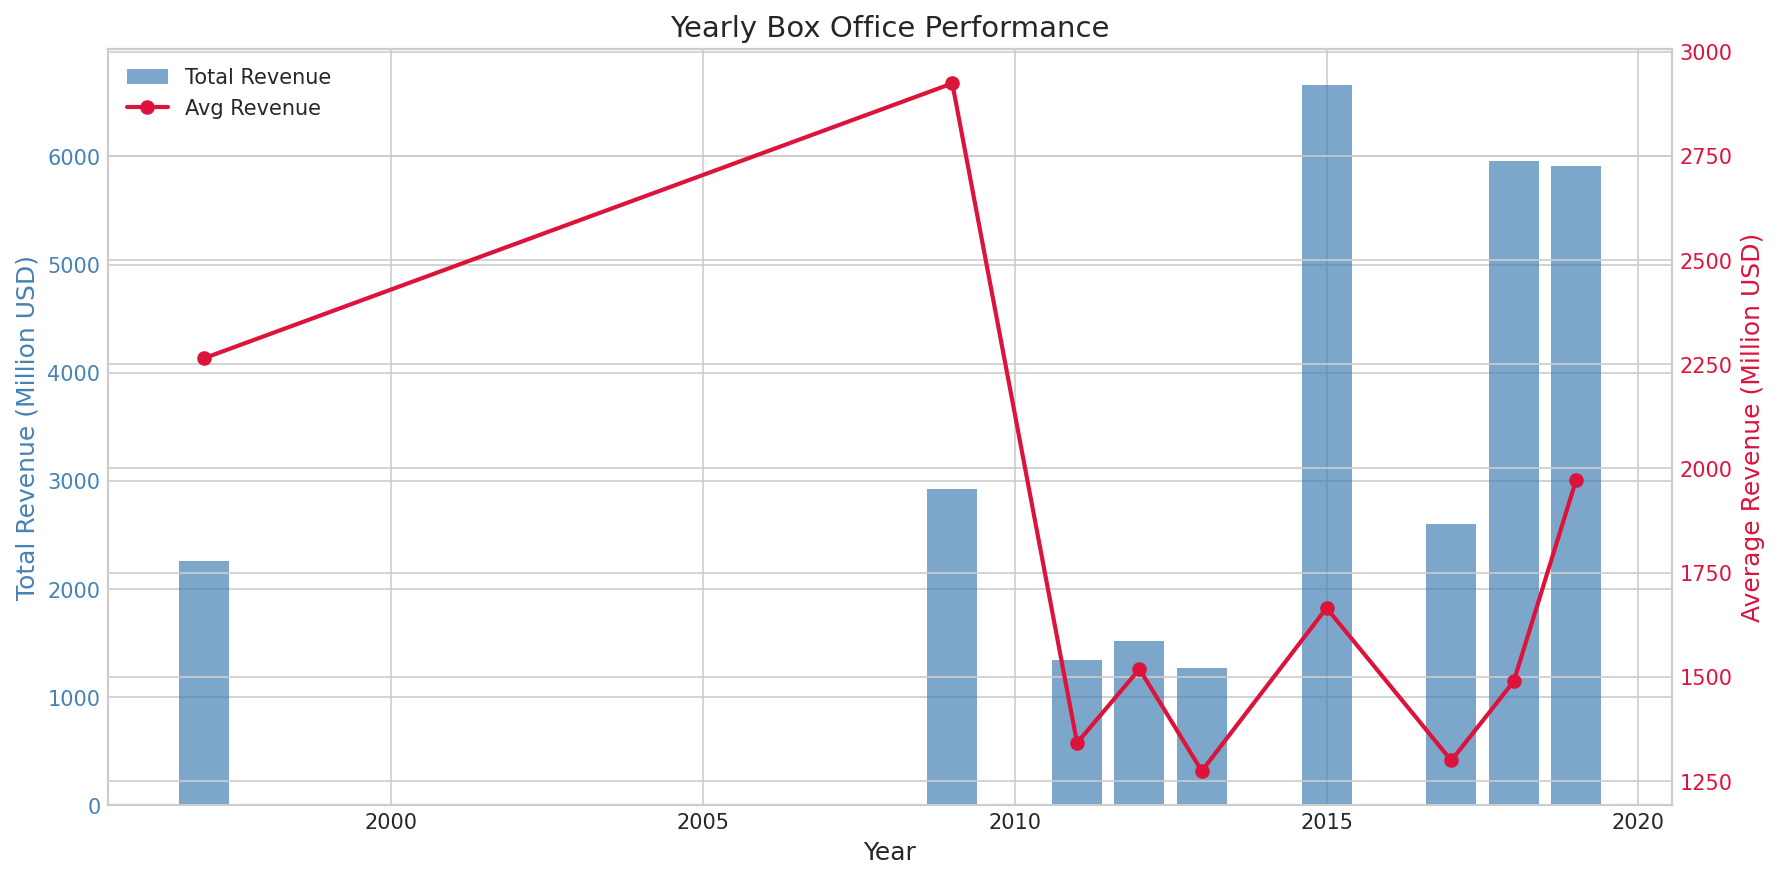


data/analytics/plots/franchise_vs_standalone.png:


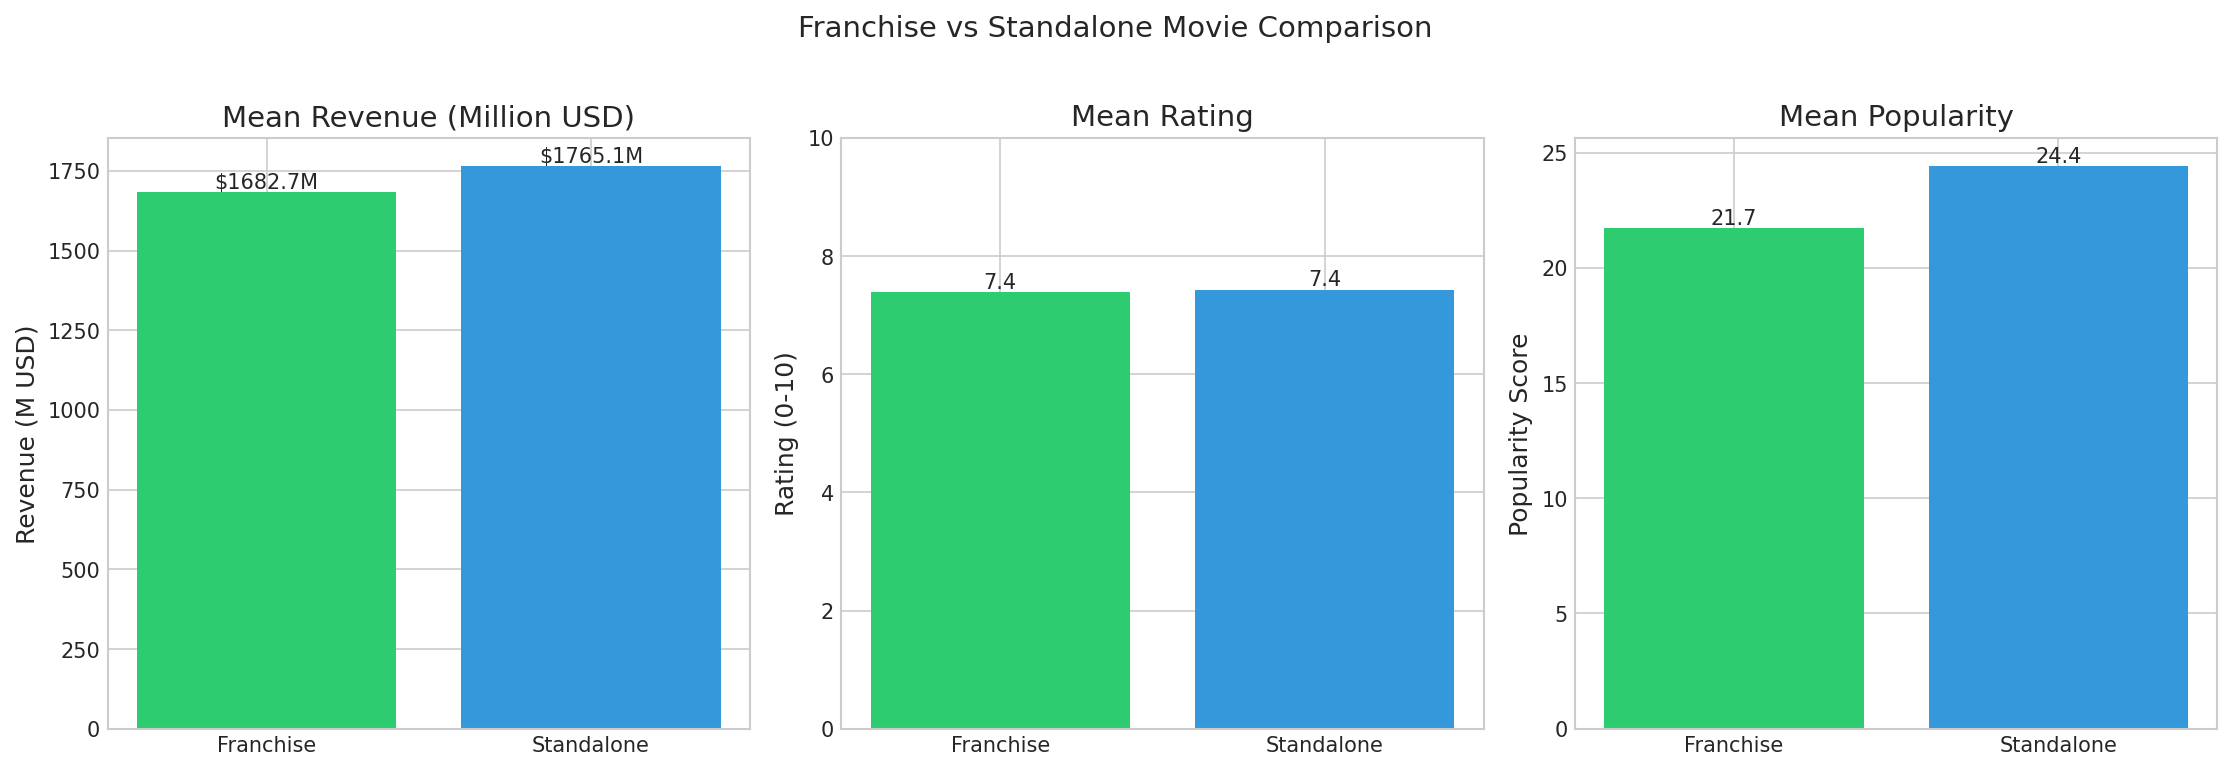

In [9]:
from src.visualization.plots import create_all_visualizations
from IPython.display import Image, display

plots = create_all_visualizations(enriched_df, 'data/analytics/plots/', comparison_df=comparison)

print(f"Created {len(plots)} visualizations")

# Display all plots inline
for plot_path in plots:
    print(f"\n{plot_path}:")
    display(Image(filename=plot_path))

## Done

In [ ]:
spark.stop()
print("Pipeline complete")